In [1]:
#import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob,iglob
import pickle
import seaborn as sns
import os, sys
import subprocess as sp
import MDAnalysis as mda
import panedr
import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
#from jupyterthemes import jtplot
#jtplot.style(theme='grade3')
#sns.set_context("paper", font_scale=2.5, rc={"lines.linewidth": 3})
#sns.set_style("ticks", {'axes.grid': True,'grid.linestyle': '--','xtick.direction': 'in','ytick.direction': 'in'})
#plt.rcParams['legend.title_fontsize'] = 'large'
plt.style.use('/cfs/klemming/projects/snic/snic2022-23-108/hargu_seaborn.mplstyle')
#%load_ext gnuplot_kernel
#%reload_ext gnuplot_kernel
#import shapely
#from shapely.geometry import LineString, Point

def line(x,m,c):
    return m*x+c
##https://reader.elsevier.com/reader/sd/pii/S003238611630074X?token=964C73218EF46E4B1D21A7BFAA533DAF02A78AD3C68728A049B766A7725EDF3DB8D80FC98810D75D0381E9CAD9D415B7&originRegion=eu-west-1&originCreation=20210611120737
def hyp(t,t0,r0,a,b,c):
    return r0+(a/2)*(t-t0)+np.sqrt((b*(t-t0)/2)**2+np.exp(c))

def hyp2(t,t0,r0,a,b):
    return r0-a*(t-t0)-b*(0.5*(t-t0)+np.sqrt((t-t0)**2)/2)


def hyperbolic_equation(t, qi, b, di):
    """
    Hyperbolic decline curve equation
    Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        b: Float. Hyperbolic decline constant
        di: Float. Nominal decline rate at time t=0
    Output: 
        Returns q, or the expected production rate at time t. Float.
    """
    return qi/((1.0+b*di*t)**(1.0/b))
def xi(m1,c1,m2,c2):
    xi = (c1-c2) / (m2-m1)
    return xi
def yi(m1,c1,m2,c2):
    xi = (c1-c2) / (m2-m1)
    yi = m1 * xi + c1
    return yi



# Marcelo PEO new ff

In [4]:
for tk in range(440,140-20,-20):
    #print(tk)
    %mkdir $tk
    with open(str(tk)+'/npt_mar_'+str(tk)+'.mdp', 'w+') as mdp:
        mdp.write('''title                   =  Tg cool PEO 

; Run parameters
integrator              = md        ; leap-frog integrator
nsteps                  = 5000000     ; 0.001 * 5000000 = 10000 ps (5ns)
dt                      = 0.001     ; 1 fs
; Output control
nstxout                 = 0    ; save coordinates every 1.0 ns
nstvout                 = 0    ; save velocities every 1.0 ns
nstxout-compressed      = 1000
nstenergy               = 100       ; save energies every 1.0 ps
nstlog                  = 500000       ; update log file every 1.0 ps
; Bond parameters
continuation            = yes       ; Restarting after NVT 
constraint_algorithm    = lincs     ; holonomic constraints 
constraints             = h-bonds   ; bonds involving H are constrained
lincs_iter              = 1         ; accuracy of LINCS
lincs_order             = 4         ; also related to accuracy
; Nonbonded settings 
cutoff-scheme           = Verlet    ; Buffered neighbor searching
ns_type                 = grid      ; search neighboring grid cells
nstlist                 = 10        ; 10 fs, largely irrelevant with Verlet scheme
rcoulomb                = 1.0       ; short-range electrostatic cutoff (in nm)
rvdw                    = 1.0       ; short-range van der Waals cutoff (in nm)
DispCorr                = EnerPres  ; account for cut-off vdW scheme
; Electrostatics
coulombtype             = PME       ; Particle Mesh Ewald for long-range electrostatics
pme_order               = 4         ; cubic interpolation
fourierspacing          = 0.16      ; grid spacing for FFT
; Temperature coupling is on
tcoupl                  = V-rescale             ; modified Berendsen thermostat
tc-grps                 = System     ; two coupling groups - more accurate
tau_t                   = 0.1    ; time constant, in ps
ref_t                   = '''+str(tk)+'''    ; reference temperature, one for each group, in K
; Pressure coupling is on
pcoupl                  = Parrinello-Rahman     ; Pressure coupling on in NPT
pcoupltype              = isotropic             ; uniform scaling of box vectors
tau_p                   = 2.0                   ; time constant, in ps
ref_p                   = 1.0                   ; reference pressure, in bar
compressibility         = 4.5e-5                ; isothermal compressibility of water, bar^-1
; Periodic boundary conditions
pbc                     = xyz       ; 3-D PBC
; Velocity generation
gen_vel                 = no        ; Velocity generation is off 
          
''')
        if tk == 440:
            grofile='../npt_dens_anneal.gro'
        else:
            grofile='../'+str(tk+20)+'/npt_mar_'+str(tk+20)+'.gro'
        with open(str(tk)+'/grotg_mar_'+str(tk)+'.sh', 'w+') as run:
            run.write('''#!/bin/bash
# time allocation
#SBATCH -A naiss2023-1-37
# name of this job
#SBATCH -o slurm_s75.out
#SBATCH -J tg'''+str(tk)+'''
# wall time for this job
#SBATCH -t 02:00:00
# partition for this job
#SBATCH -p main

# number of nodes
#SBATCH --nodes=2
# number of MPI processes per node
#SBATCH --ntasks-per-node=128
export OMP_NUM_THREADS=1

ml PDC
ml gromacs/2020.7-cpeCray-22.06
#rm \#* dd* npt_s75_'''+str(tk)+'''.tpr
srun -n 1 gmx grompp -f npt_mar_'''+str(tk)+'''.mdp -c '''+str(grofile)+''' -p ../topol_PEO.top -o npt_mar_'''+str(tk)+'''.tpr -maxwarn 2

# the -N keyword to aprun specifies how many processes to run on each node
srun gmx_mpi mdrun -s npt_mar_'''+str(tk)+'''.tpr -deffnm npt_mar_'''+str(tk)+'''

#rm \#*
''')
                   

mkdir: cannot create directory ‘400’: File exists
mkdir: cannot create directory ‘380’: File exists
mkdir: cannot create directory ‘360’: File exists
mkdir: cannot create directory ‘340’: File exists
mkdir: cannot create directory ‘320’: File exists
mkdir: cannot create directory ‘300’: File exists
mkdir: cannot create directory ‘280’: File exists
mkdir: cannot create directory ‘260’: File exists
mkdir: cannot create directory ‘240’: File exists
mkdir: cannot create directory ‘220’: File exists
mkdir: cannot create directory ‘200’: File exists
mkdir: cannot create directory ‘180’: File exists
mkdir: cannot create directory ‘160’: File exists
mkdir: cannot create directory ‘140’: File exists


In [7]:
%%bash
n=440
cd $n
coltgo=$(sbatch grotg_mar_$n.sh)
id=$(grep -Eo '[0-9]+' <<<"$coltgo")
echo "job submitted for Tg cool 440 K: $id"
cd ..

for n in 420 400 380 360 340 320 300 280 260 240 220 200 180 160 140; do
	cd $n
	coltgo=$(sbatch --dependency=afterany:$id grotg_mar_$n.sh);
	id=$(grep -Eo '[0-9]+' <<<"$coltgo");
	echo "job submitted for Tg cool $n K: $id"
	cd ..
done

job submitted for Tg cool 440 K: 2587527
job submitted for Tg cool 420 K: 2587528
job submitted for Tg cool 400 K: 2587529
job submitted for Tg cool 380 K: 2587530
job submitted for Tg cool 360 K: 2587531
job submitted for Tg cool 340 K: 2587532
job submitted for Tg cool 320 K: 2587533
job submitted for Tg cool 300 K: 2587534
job submitted for Tg cool 280 K: 2587535
job submitted for Tg cool 260 K: 2587536
job submitted for Tg cool 240 K: 2587537
job submitted for Tg cool 220 K: 2587538
job submitted for Tg cool 200 K: 2587539
job submitted for Tg cool 180 K: 2587540
job submitted for Tg cool 160 K: 2587541
job submitted for Tg cool 140 K: 2587542


In [9]:
df_tg=pd.DataFrame()
temp=list(range(140,441,20))
den_mean_mar=[];den_std_mar=[]
for i,t in enumerate(temp):
    df_tg.at[i,'T_K']=t
    df = panedr.edr_to_df(str(t)+'/npt_mar_'+str(t)+'.edr')
    #Block averaging of density
    #Divides the coloumn into groups of 100 data points and takes average of this groups
    groups = pd.Series(np.repeat(range(int(len(df["Density"][2500:])/100)), 100))
    grouped = df["Density"].groupby(groups)
    den_mean_mar.append(grouped.agg('mean').mean())
    den_std_mar.append(grouped.agg('mean').std())
    df_tg.at[i,'den_mean_mar']=grouped.agg('mean').mean()
    df_tg.at[i,'den_std_mar']=grouped.agg('mean').std()

In [ ]:
df_tg

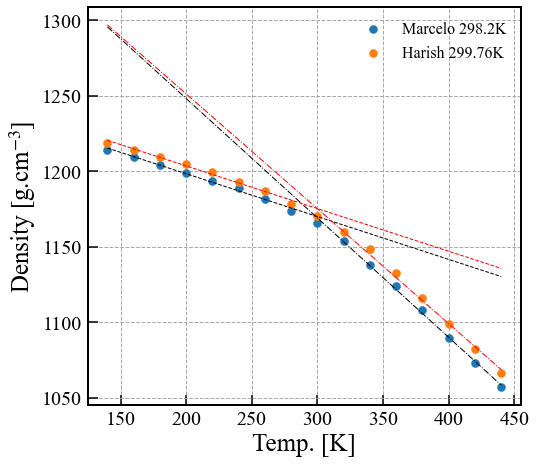

In [10]:
fig,axs=plt.subplots(1,1,figsize=(8*1,7))

fitT_idx0, fitT_idx1,fitT_idx2=[0,7,8]

low_T=temp[fitT_idx0:fitT_idx1+1];high_T=temp[fitT_idx2:]
low_C=den_mean_mar[fitT_idx0:fitT_idx1+1];high_C=den_mean_mar[fitT_idx2:]
m_high, c_high = np.polyfit(high_T, high_C, 1);m_low, c_low = np.polyfit(low_T, low_C, 1)
tg_cal=(c_low-c_high)/(m_high-m_low)
axs.plot(temp,[m_high*tk+c_high for tk in temp],'k-.',lw=1);axs.plot(temp,[m_low*tk+c_low for tk in temp],'k--',lw=1)
axs.scatter(temp,den_mean_mar,label='Marcelo '+str(np.round(tg_cal,2))+'K')

low_T=temp[fitT_idx0:fitT_idx1+1];high_T=temp[fitT_idx2:]
low_C=den_mean_har[fitT_idx0:fitT_idx1+1];high_C=den_mean_har[fitT_idx2:]
m_high, c_high = np.polyfit(high_T, high_C, 1);m_low, c_low = np.polyfit(low_T, low_C, 1)
tg_cal=(c_low-c_high)/(m_high-m_low)
axs.plot(temp,[m_high*tk+c_high for tk in temp],'r-.',lw=1);axs.plot(temp,[m_low*tk+c_low for tk in temp],'r--',lw=1)
axs.scatter(temp,den_mean_har,label='Harish '+str(np.round(tg_cal,2))+'K')

axs.legend(fontsize=16)
axs.set_xlabel('Temp. [K]');axs.set_ylabel('Density [g.cm$^{-3}$]')

plt.tight_layout()

# Harish PEO CH3 120mer

In [ ]:
pack=open('packmol_bulk.inp','w+')
pack.write('tolerance 2.0'+'\n'+
              'filetype pdb'+'\n'+
              'output PEO_har_initial.pdb'+'\n'+
              #'structure ../../polymer_builder/'+str(pdir_nmon)+'/'+str(pdir_nmon)+'_polymer.pdb'+'\n'+
              'structure ../GroPolBul/polymers/PEO_CH3_120mer/PEO_single_em.pdb'+'\n'+           
              'number 20'+'\n'+
#              '  inside cube 0. 0. 0. '+str(int(maxbox+1))+'\n'+
              '  inside cube 0. 0. 0. 100.'+'\n'+           
              'end structure'
          )
pack.close()
!../packmol < packmol_bulk.inp


In [21]:
852*20

17040

In [34]:
%%writefile run.sh
#!/bin/bash
# time allocation
#SBATCH -A naiss2023-1-37
# name of this job
#SBATCH -o slurm.out
#SBATCH -J sys_eq
# wall time for this job
#SBATCH -t 04:00:00
# partition for this job
#SBATCH -p main

# number of nodes
#SBATCH --nodes=1
# number of MPI processes per node
#SBATCH --ntasks-per-node=128
export OMP_NUM_THREADS=1

ml PDC
ml gromacs

cd md
mdp=/cfs/klemming/projects/snic/snic2022-23-108/GroPolBul/mdp
top=../PEO_har_polymer_GMX.top
#rm npt*
#srun -n 1 gmx editconf -f ../PEO_har_initial.pdb -bt cubic -d 0 -o preem.gro
#######EM
#srun -n 1 gmx grompp -f $mdp/em.mdp -c preem.gro -p $top -o em.tpr -v 
#srun gmx_mpi mdrun -v -deffnm em
#######NVE
#srun -n 1 gmx grompp -f $mdp/md.mdp -c em.gro -p $top -o md.tpr
#srun gmx_mpi mdrun -deffnm md -nsteps 5000 -v
#######NVT
#srun -n 1 gmx grompp -f $mdp/nvt.mdp -c md.gro -p $top -o nvt.tpr -maxwarn 2
#srun gmx_mpi mdrun -deffnm nvt -nsteps 10000000 -v
#######NPT
#srun -n 1 gmx editconf -f nvt.gro -bt cubic -d 0.1 -o nvt_small.gro
#srun -n 1 gmx grompp -f $mdp/npt.mdp -c nvt_small.gro -p $top -o npt.tpr -maxwarn 2
#srun gmx_mpi mdrun -cpi npt.cpt -deffnm npt -nsteps 10000000 -v

#######NPT2
srun -n 1 gmx grompp -f $mdp/npt.mdp -c npt.gro -p $top -o npt2.tpr -maxwarn 2
srun gmx_mpi mdrun -deffnm npt2 -nsteps 100000 -v

rm \#*


Overwriting run.sh


In [35]:
!sbatch run.sh

Submitted batch job 2745069


In [2]:
#!scancel -u hargu978
!squeue -u hargu978 #--start
!tail slurm.out

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
      e.g. by using fewer domains along the box dimension in which there is
      considerable inhomogeneity in the simulated system.

               Core t (s)   Wall t (s)        (%)
       Time:     3844.935       30.040    12799.3
                 (ns/day)    (hour/ns)
Performance:      287.619        0.083

GROMACS reminds you: "I think it's very important to get more women into computing. My slogan is: Computing is too important to be left to men." (Karen Jones)



In [43]:
df=panedr.edr_to_df('md/npt2.edr')
clm=df.columns
#clm

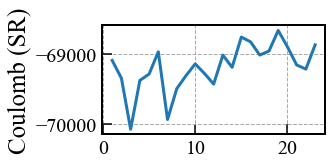

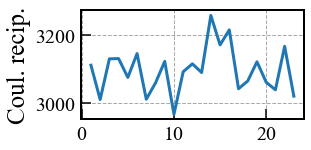

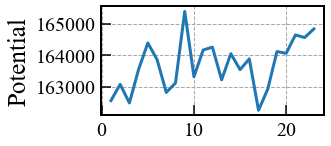

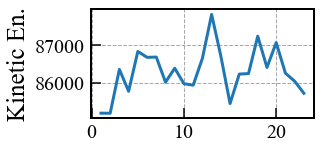

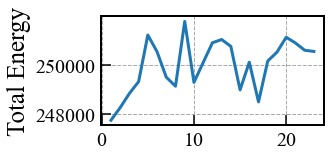

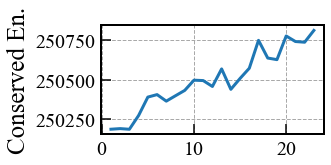

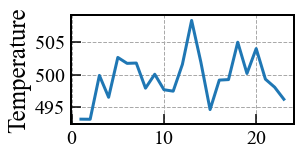

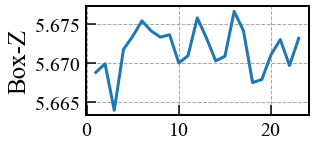

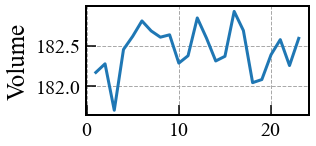

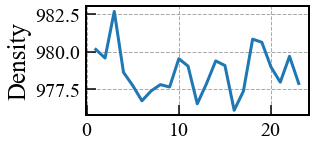

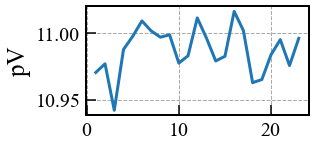

In [44]:
for i in list(range(7,14)) + [18,19,20,21]:
    plt.figure(figsize=(4,2))
    plt.plot(df[clm[0]][1:],df[clm[i]][1:])
    plt.ylabel(clm[i]);#plt.xlabel(clm[0]);
    plt.show()

In [45]:
for tk in range(440,140-20,-20):
    #print(tk)
    #%mkdir $tk
    with open(str(tk)+'/npt_har_'+str(tk)+'.mdp', 'w+') as mdp:
        mdp.write('''title                   =  Tg cool PEO 

; Run parameters
integrator              = md        ; leap-frog integrator
nsteps                  = 5000000     ; 0.001 * 5000000 = 10000 ps (5ns)
dt                      = 0.001     ; 1 fs
; Output control
nstxout                 = 0    ; save coordinates every 1.0 ns
nstvout                 = 0    ; save velocities every 1.0 ns
nstxout-compressed      = 1000
nstenergy               = 100       ; save energies every 1.0 ps
nstlog                  = 500000       ; update log file every 1.0 ps
; Bond parameters
continuation            = yes       ; Restarting after NVT 
constraint_algorithm    = lincs     ; holonomic constraints 
constraints             = h-bonds   ; bonds involving H are constrained
lincs_iter              = 1         ; accuracy of LINCS
lincs_order             = 4         ; also related to accuracy
; Nonbonded settings 
cutoff-scheme           = Verlet    ; Buffered neighbor searching
ns_type                 = grid      ; search neighboring grid cells
nstlist                 = 10        ; 10 fs, largely irrelevant with Verlet scheme
rcoulomb                = 1.0       ; short-range electrostatic cutoff (in nm)
rvdw                    = 1.0       ; short-range van der Waals cutoff (in nm)
DispCorr                = EnerPres  ; account for cut-off vdW scheme
; Electrostatics
coulombtype             = PME       ; Particle Mesh Ewald for long-range electrostatics
pme_order               = 4         ; cubic interpolation
fourierspacing          = 0.16      ; grid spacing for FFT
; Temperature coupling is on
tcoupl                  = V-rescale             ; modified Berendsen thermostat
tc-grps                 = System     ; two coupling groups - more accurate
tau_t                   = 0.1    ; time constant, in ps
ref_t                   = '''+str(tk)+'''    ; reference temperature, one for each group, in K
; Pressure coupling is on
pcoupl                  = Parrinello-Rahman     ; Pressure coupling on in NPT
pcoupltype              = isotropic             ; uniform scaling of box vectors
tau_p                   = 2.0                   ; time constant, in ps
ref_p                   = 1.0                   ; reference pressure, in bar
compressibility         = 4.5e-5                ; isothermal compressibility of water, bar^-1
; Periodic boundary conditions
pbc                     = xyz       ; 3-D PBC
; Velocity generation
gen_vel                 = no        ; Velocity generation is off 
          
''')
        if tk == 440:
            grofile='../md/npt2.gro'
        else:
            grofile='../'+str(tk+20)+'/npt_har_'+str(tk+20)+'.gro'
        with open(str(tk)+'/grotg_har_'+str(tk)+'.sh', 'w+') as run:
            run.write('''#!/bin/bash
# time allocation
#SBATCH -A naiss2023-1-37
# name of this job
#SBATCH -o slurm_s75.out
#SBATCH -J tg'''+str(tk)+'''
# wall time for this job
#SBATCH -t 02:00:00
# partition for this job
#SBATCH -p main

# number of nodes
#SBATCH --nodes=2
# number of MPI processes per node
#SBATCH --ntasks-per-node=128
export OMP_NUM_THREADS=1

ml PDC
ml gromacs/2020.7-cpeCray-22.06
rm npt_har_'''+str(tk)+'''.tpr
srun -n 1 gmx grompp -f npt_har_'''+str(tk)+'''.mdp -c '''+str(grofile)+''' -p ../PEO_har_polymer_GMX.top -o npt_har_'''+str(tk)+'''.tpr -maxwarn 2

# the -N keyword to aprun specifies how many processes to run on each node
srun gmx_mpi mdrun -s npt_har_'''+str(tk)+'''.tpr -deffnm npt_har_'''+str(tk)+'''

rm \#*
''')
                   

In [46]:
%%bash
n=440
cd $n
coltgo=$(sbatch grotg_har_$n.sh)
id=$(grep -Eo '[0-9]+' <<<"$coltgo")
echo "job submitted for Tg cool 440 K: $id"
cd ..

for n in 420 400 380 360 340 320 300 280 260 240 220 200 180 160 140; do
	cd $n
	coltgo=$(sbatch --dependency=afterany:$id grotg_har_$n.sh);
	id=$(grep -Eo '[0-9]+' <<<"$coltgo");
	echo "job submitted for Tg cool $n K: $id"
	cd ..
done

job submitted for Tg cool 440 K: 2745077
job submitted for Tg cool 420 K: 2745078
job submitted for Tg cool 400 K: 2745079
job submitted for Tg cool 380 K: 2745080
job submitted for Tg cool 360 K: 2745081
job submitted for Tg cool 340 K: 2745082
job submitted for Tg cool 320 K: 2745083
job submitted for Tg cool 300 K: 2745084
job submitted for Tg cool 280 K: 2745085
job submitted for Tg cool 260 K: 2745086
job submitted for Tg cool 240 K: 2745087
job submitted for Tg cool 220 K: 2745088
job submitted for Tg cool 200 K: 2745089
job submitted for Tg cool 180 K: 2745090
job submitted for Tg cool 160 K: 2745091
job submitted for Tg cool 140 K: 2745092


In [65]:
!squeue -u hargu978 #--start

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           2742143      main    tg140 hargu978 PD       0:00      2 (Dependency)
           2742142      main    tg160 hargu978 PD       0:00      2 (Dependency)
           2742141      main    tg180 hargu978 PD       0:00      2 (Dependency)
           2742140      main    tg200 hargu978 PD       0:00      2 (Dependency)
           2742139      main    tg220 hargu978 PD       0:00      2 (Dependency)
           2742138      main    tg240 hargu978 PD       0:00      2 (Dependency)
           2742137      main    tg260 hargu978 PD       0:00      2 (Dependency)
           2742136      main    tg280 hargu978 PD       0:00      2 (Dependency)
           2742135      main    tg300 hargu978 PD       0:00      2 (Dependency)
           2742134      main    tg320 hargu978 PD       0:00      2 (Dependency)
           2742133      main    tg340 hargu978 PD       0:00      2 (Dependency)
           2742132      

In [57]:
%%bash
for i in {2742089..2742104};do
scancel $i
done

In [10]:
temp=list(range(140,441,20))
den_mean_har=[];den_std_har=[]
for i,t in enumerate(temp):
    df = panedr.edr_to_df(str(t)+'/npt_har_'+str(t)+'.edr')
    #Block averaging of density
    #Divides the coloumn into groups of 100 data points and takes average of this groups
    groups = pd.Series(np.repeat(range(int(len(df["Density"][2500:])/100)), 100))
    grouped = df["Density"].groupby(groups)
    den_mean_har.append(grouped.agg('mean').mean())
    den_std_har.append(grouped.agg('mean').std())
    df_tg.at[i,'den_mean_har']=grouped.agg('mean').mean()
    df_tg.at[i,'den_std_har']=grouped.agg('mean').std()

In [12]:
df_tg.to_csv('temp_density_mar_har.csv',index=None)

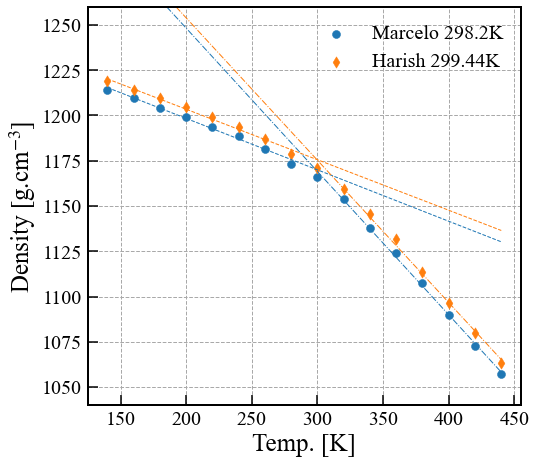

In [11]:
fig,axs=plt.subplots(1,1,figsize=(8*1,7))

fitT_idx0, fitT_idx1,fitT_idx2=[0,7,8]

low_T=temp[fitT_idx0:fitT_idx1+1];high_T=temp[fitT_idx2:]
low_C=den_mean_mar[fitT_idx0:fitT_idx1+1];high_C=den_mean_mar[fitT_idx2:]
m_high, c_high = np.polyfit(high_T, high_C, 1);m_low, c_low = np.polyfit(low_T, low_C, 1)
tg_cal=(c_low-c_high)/(m_high-m_low)
axs.plot(temp,[m_high*tk+c_high for tk in temp],color='tab:blue',ls='-.',lw=1);axs.plot(temp,[m_low*tk+c_low for tk in temp],color='tab:blue',ls='--',lw=1)
axs.scatter(temp,den_mean_mar,label='Marcelo '+str(np.round(tg_cal,2))+'K',marker='o')

low_T=temp[fitT_idx0:fitT_idx1+1];high_T=temp[fitT_idx2:]
low_C=den_mean_har[fitT_idx0:fitT_idx1+1];high_C=den_mean_har[fitT_idx2:]
m_high, c_high = np.polyfit(high_T, high_C, 1);m_low, c_low = np.polyfit(low_T, low_C, 1)
tg_cal=(c_low-c_high)/(m_high-m_low)
axs.plot(temp,[m_high*tk+c_high for tk in temp],color='tab:orange',ls='-.',lw=1);axs.plot(temp,[m_low*tk+c_low for tk in temp],color='tab:orange',ls='--',lw=1)
axs.scatter(temp,den_mean_har,label='Harish '+str(np.round(tg_cal,2))+'K',marker='d')
axs.set_ylim(1040,1260)
axs.legend(fontsize=20)
axs.set_xlabel('Temp. [K]');axs.set_ylabel('Density [g.cm$^{-3}$]')

plt.tight_layout()